In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset as hf_load_dataset
import numpy as np
from collections import defaultdict

import sys
sys.path.insert(0, '.')
from train import HFImageDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Load dataset
hf_ds = hf_load_dataset("hsyntemiz/turcoins")
class_names = hf_ds["train"].features["label"].names
num_classes = len(class_names)
print(f"Classes: {num_classes}")
print(f"Train: {len(hf_ds['train'])}, Test: {len(hf_ds['test'])}")

# Test transforms (deterministic)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

test_dataset = HFImageDataset(hf_ds["test"], transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Load model
model = models.vit_b_16(weights=None)
model.heads = nn.Sequential(
    nn.LayerNorm(768),
    nn.Dropout(0.1),
    nn.Linear(768, num_classes),
)
ckpt = torch.load("outputs/turcoins_classifier/best_model.pt", map_location="cpu", weights_only=False)
model.load_state_dict(ckpt["model"])
model = model.to(device)
model.eval()
print(f"Loaded best model (epoch {ckpt['epoch']+1}, best acc: {ckpt['best_accuracy']:.4f})")

/home/dipcik/phdprojects/pilab/drifting-model-coins/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Classes: 138
Train: 9352, Test: 1728
Loaded best model (epoch 41, best acc: 0.9769)


In [2]:
# Collect all predictions and ground truth
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            logits = model(images)
        preds = logits.argmax(1).cpu()
        all_preds.append(preds)
        all_labels.append(labels)

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
print(f"Total test samples: {len(all_preds)}")
print(f"Overall accuracy: {(all_preds == all_labels).mean():.4f}")

Total test samples: 1728
Overall accuracy: 0.9769


In [3]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, accuracy_score,
    top_k_accuracy_score
)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

# Overall metrics
accuracy = accuracy_score(all_labels, all_preds)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

print("=" * 60)
print("GENEL SINIFLANDIRMA METRIKLERI")
print("=" * 60)
print(f"  Accuracy:           {accuracy:.4f}")
print(f"  Macro Precision:    {precision_macro:.4f}")
print(f"  Macro Recall:       {recall_macro:.4f}")
print(f"  Macro F1-Score:     {f1_macro:.4f}")
print(f"  Weighted Precision: {precision_weighted:.4f}")
print(f"  Weighted Recall:    {recall_weighted:.4f}")
print(f"  Weighted F1-Score:  {f1_weighted:.4f}")
print("=" * 60)

GENEL SINIFLANDIRMA METRIKLERI
  Accuracy:           0.9769
  Macro Precision:    0.9698
  Macro Recall:       0.9550
  Macro F1-Score:     0.9573
  Weighted Precision: 0.9792
  Weighted Recall:    0.9769
  Weighted F1-Score:  0.9761


In [4]:
# Per-class metrics
precision_per, recall_per, f1_per, support_per = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)

# Sort by F1 score ascending to find worst classes
sorted_by_f1 = np.argsort(f1_per)

print("=" * 80)
print("EN KOTU PERFORMANS GOSTEREN 20 SINIF (F1 Score'a gore)")
print("=" * 80)
print(f"{'Sinif':>8} | {'Precision':>9} | {'Recall':>6} | {'F1':>6} | {'Support':>7} | {'Dogru':>5}")
print("-" * 80)
for idx in sorted_by_f1[:20]:
    correct = int(support_per[idx] * recall_per[idx])
    print(f"{class_names[idx]:>8} | {precision_per[idx]:>9.4f} | {recall_per[idx]:>6.4f} | {f1_per[idx]:>6.4f} | {support_per[idx]:>7} | {correct:>5}")

print()
print("=" * 80)
print("EN IYI PERFORMANS GOSTEREN 20 SINIF (F1 Score'a gore)")
print("=" * 80)
print(f"{'Sinif':>8} | {'Precision':>9} | {'Recall':>6} | {'F1':>6} | {'Support':>7} | {'Dogru':>5}")
print("-" * 80)
for idx in sorted_by_f1[-20:][::-1]:
    correct = int(support_per[idx] * recall_per[idx])
    print(f"{class_names[idx]:>8} | {precision_per[idx]:>9.4f} | {recall_per[idx]:>6.4f} | {f1_per[idx]:>6.4f} | {support_per[idx]:>7} | {correct:>5}")

EN KOTU PERFORMANS GOSTEREN 20 SINIF (F1 Score'a gore)
   Sinif | Precision | Recall |     F1 | Support | Dogru
--------------------------------------------------------------------------------
   10251 |    1.0000 | 0.3333 | 0.5000 |       3 |     1
    9631 |    1.0000 | 0.3333 | 0.5000 |       3 |     1
    9751 |    0.6667 | 0.5000 | 0.5714 |       4 |     2
    9670 |    0.7500 | 0.6000 | 0.6667 |       5 |     3
    9661 |    0.6667 | 0.6667 | 0.6667 |       6 |     4
    9641 |    0.6250 | 0.8333 | 0.7143 |       6 |     5
    8611 |    1.0000 | 0.5714 | 0.7273 |       7 |     4
    9871 |    1.0000 | 0.6000 | 0.7500 |       5 |     3
    9660 |    0.7143 | 0.8333 | 0.7692 |       6 |     5
    9971 |    0.8000 | 0.8000 | 0.8000 |       5 |     4
   12411 |    1.0000 | 0.6667 | 0.8000 |       3 |     2
    9881 |    1.0000 | 0.7143 | 0.8333 |       7 |     5
   11371 |    1.0000 | 0.7500 | 0.8571 |       4 |     3
   12401 |    0.7500 | 1.0000 | 0.8571 |       3 |     3
    9440 

In [5]:
# KARISTIRMA (CONFUSION) ANALIZI
# Hangi siniflar birbirleriyle karistirildi?
cm = confusion_matrix(all_labels, all_preds)

# Off-diagonal confusions: find pairs (true, pred) with most errors
confusions = []
for i in range(num_classes):
    for j in range(num_classes):
        if i != j and cm[i, j] > 0:
            confusions.append((cm[i, j], class_names[i], class_names[j], i, j))
confusions.sort(reverse=True)

print("=" * 80)
print("EN COK KARISTIRILAN SINIF CIFTLERI")
print("(Gercek sinif -> Tahmin edilen sinif, kac kez)")
print("=" * 80)
for count, true_name, pred_name, ti, pi in confusions[:25]:
    # Check if they are front/back pairs (consecutive IDs like 8860/8861)
    pair_note = ""
    try:
        t_num, p_num = int(true_name), int(pred_name)
        if abs(t_num - p_num) == 1:
            pair_note = " <-- ON/ARKA YUZ CIFTI"
    except ValueError:
        pass
    print(f"  {true_name:>6} -> {pred_name:<6} : {count} hata{pair_note}")

EN COK KARISTIRILAN SINIF CIFTLERI
(Gercek sinif -> Tahmin edilen sinif, kac kez)
    8611 -> 8621   : 3 hata
    9670 -> 9660   : 2 hata
    9631 -> 9641   : 2 hata
    8871 -> 8881   : 2 hata
    8690 -> 8660   : 2 hata
    8621 -> 8631   : 2 hata
    9971 -> 10151  : 1 hata
    9891 -> 10271  : 1 hata
    9881 -> 9891   : 1 hata
    9881 -> 10411  : 1 hata
    9871 -> 9661   : 1 hata
    9871 -> 10271  : 1 hata
    9870 -> 9880   : 1 hata
    9751 -> 9661   : 1 hata
    9751 -> 9641   : 1 hata
    9671 -> 9891   : 1 hata
    9661 -> 9891   : 1 hata
    9661 -> 9651   : 1 hata
    9660 -> 9670   : 1 hata
    9641 -> 9751   : 1 hata
    9440 -> 9050   : 1 hata
    8951 -> 8911   : 1 hata
    8891 -> 10271  : 1 hata
    8871 -> 8861   : 1 hata
    8830 -> 8850   : 1 hata


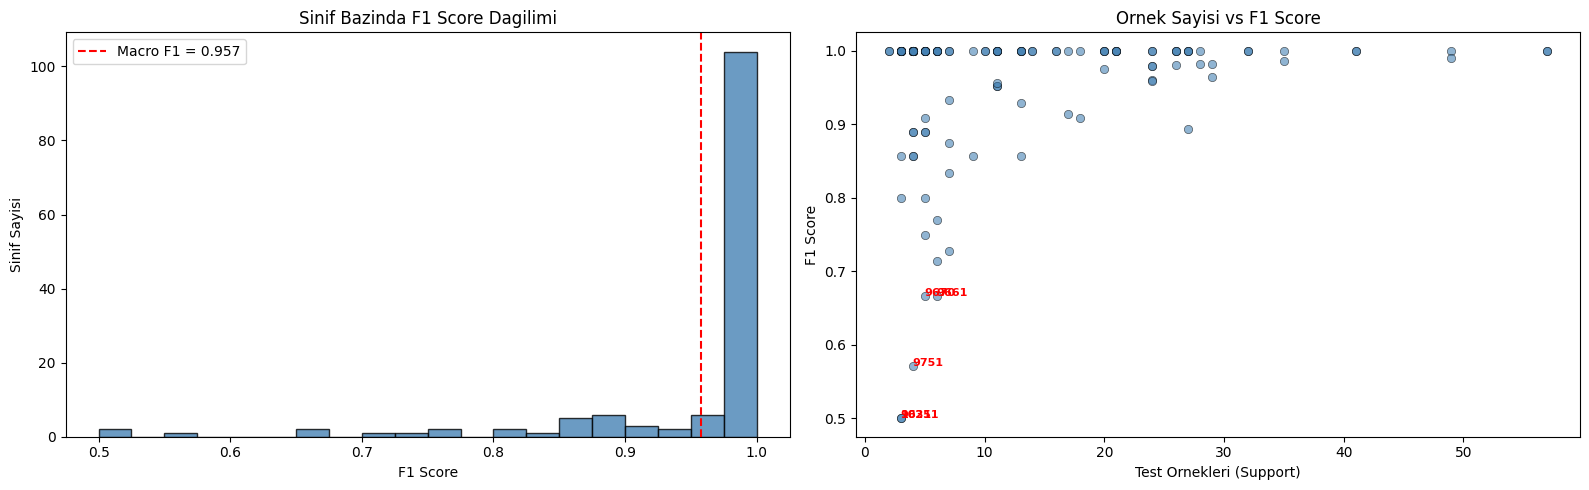

Saved: outputs/turcoins_classifier/f1_distribution.png


In [6]:
# F1 Score dagilimi histogrami
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# F1 distribution
axes[0].hist(f1_per, bins=20, edgecolor='black', color='steelblue', alpha=0.8)
axes[0].axvline(f1_macro, color='red', linestyle='--', label=f'Macro F1 = {f1_macro:.3f}')
axes[0].set_xlabel('F1 Score')
axes[0].set_ylabel('Sinif Sayisi')
axes[0].set_title('Sinif Bazinda F1 Score Dagilimi')
axes[0].legend()

# Support vs F1 scatter
axes[1].scatter(support_per, f1_per, alpha=0.6, c='steelblue', edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Test Ornekleri (Support)')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Ornek Sayisi vs F1 Score')
# Annotate worst
for idx in sorted_by_f1[:5]:
    axes[1].annotate(class_names[idx], (support_per[idx], f1_per[idx]),
                     fontsize=8, color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/turcoins_classifier/f1_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: outputs/turcoins_classifier/f1_distribution.png")

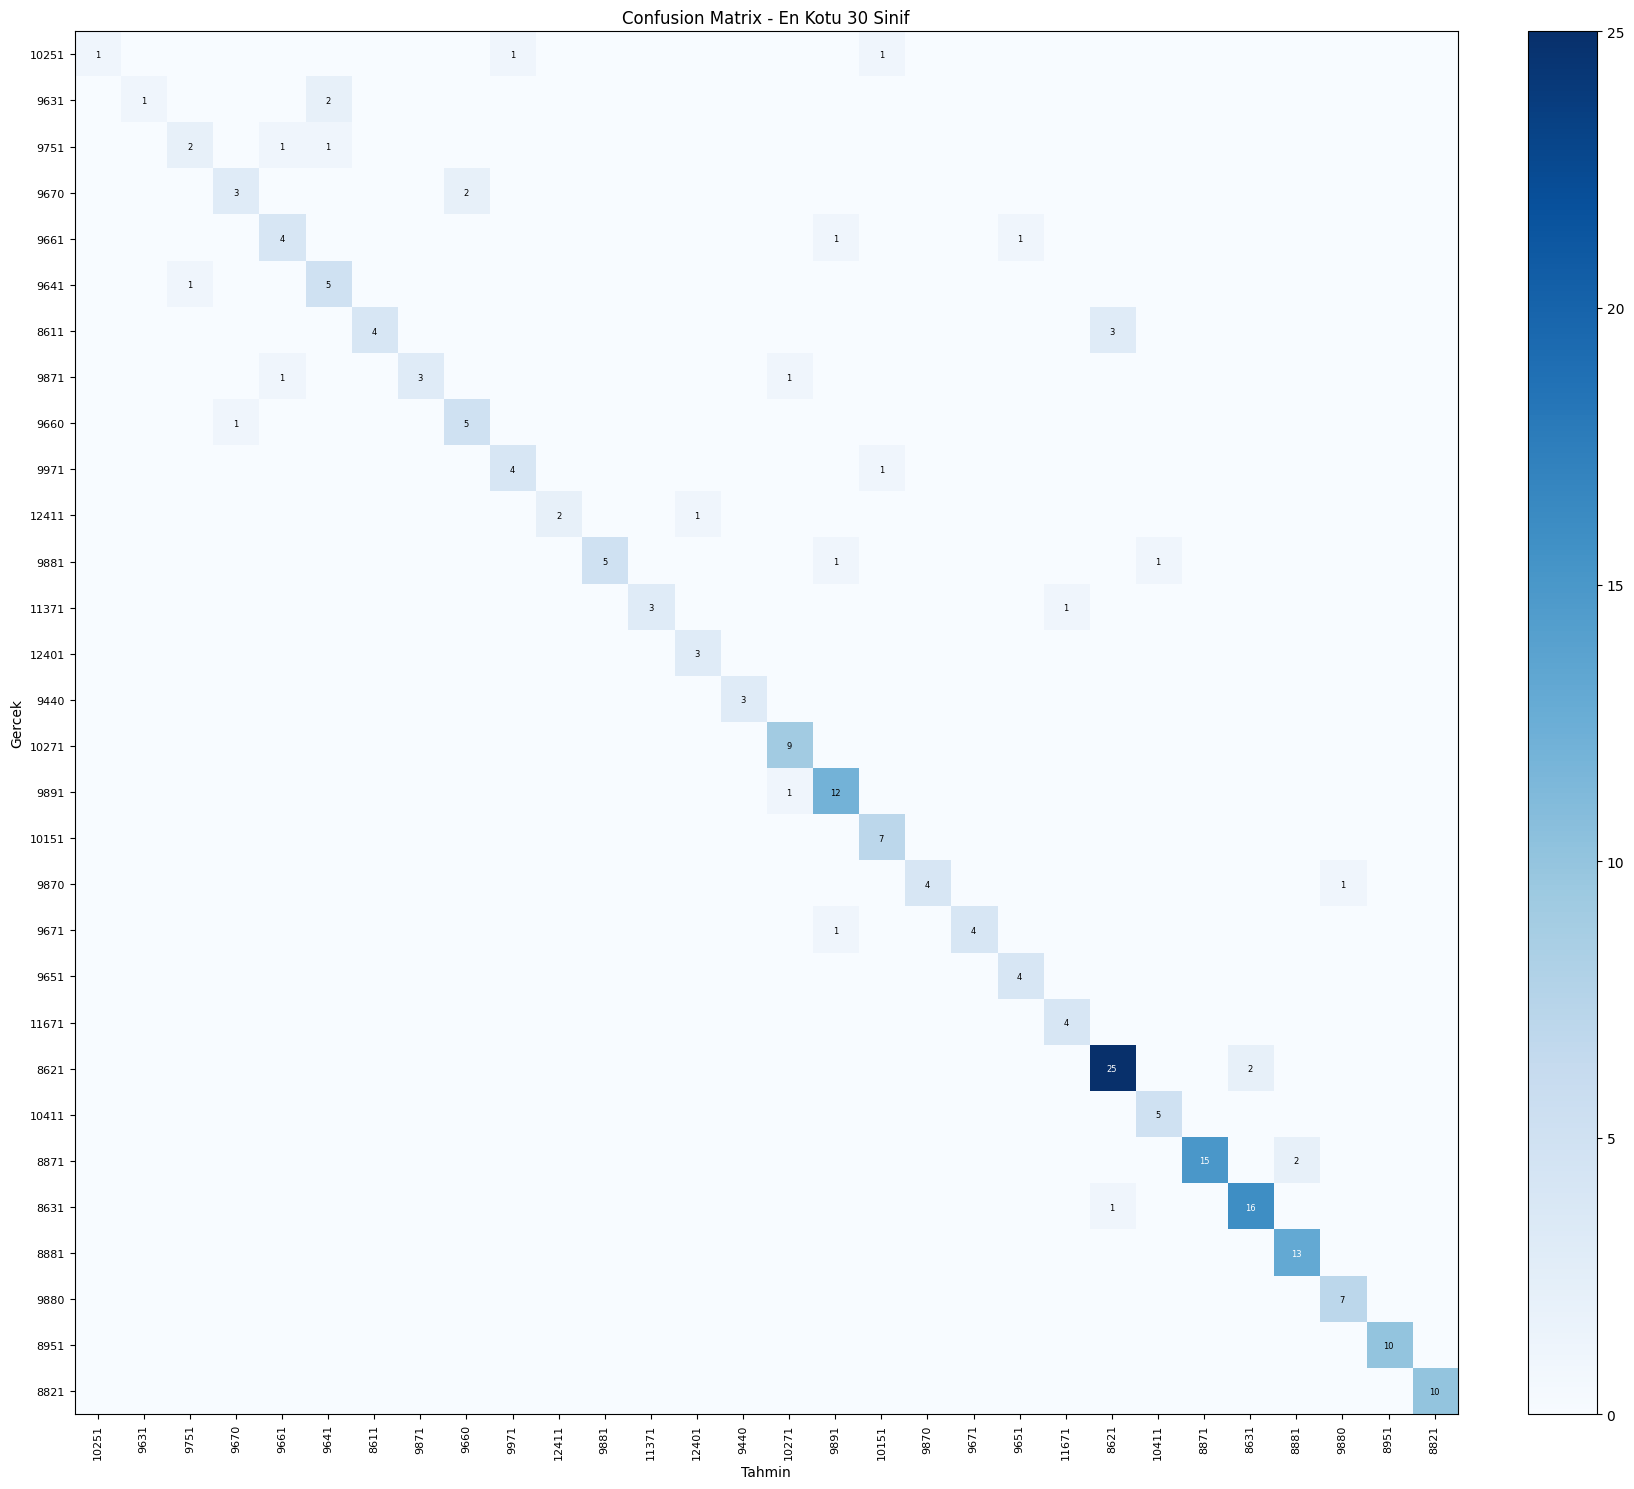

Saved: outputs/turcoins_classifier/confusion_matrix_worst.png


In [7]:
# Confusion matrix - sadece en cok hata yapan siniflar icin
# En kotu 30 sinifi bul
worst_k = 30
worst_indices = sorted_by_f1[:worst_k]
worst_names = [class_names[i] for i in worst_indices]

# Sub-matrix
cm_worst = cm[np.ix_(worst_indices, worst_indices)]

fig, ax = plt.subplots(figsize=(18, 15))
im = ax.imshow(cm_worst, cmap='Blues', interpolation='nearest')
ax.set_xticks(range(worst_k))
ax.set_yticks(range(worst_k))
ax.set_xticklabels(worst_names, rotation=90, fontsize=8)
ax.set_yticklabels(worst_names, fontsize=8)
ax.set_xlabel('Tahmin')
ax.set_ylabel('Gercek')
ax.set_title(f'Confusion Matrix - En Kotu {worst_k} Sinif')

# Annotate cells
for i in range(worst_k):
    for j in range(worst_k):
        val = cm_worst[i, j]
        if val > 0:
            color = 'white' if val > cm_worst.max() / 2 else 'black'
            ax.text(j, i, str(val), ha='center', va='center', fontsize=6, color=color)

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig('outputs/turcoins_classifier/confusion_matrix_worst.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: outputs/turcoins_classifier/confusion_matrix_worst.png")

In [8]:
# On/Arka yuz cift analizi
# Sinif isimleri ardisik sayilar (8860/8861 = on/arka yuz)
print("=" * 80)
print("ON/ARKA YUZ CIFTI ANALIZI")
print("(Ardisik siniflar: XXX0=on yuz, XXX1=arka yuz)")
print("=" * 80)

pair_confusions = []
for i in range(0, num_classes - 1, 2):
    name_i = class_names[i]
    name_j = class_names[i + 1]
    try:
        num_i, num_j = int(name_i), int(name_j)
        if num_j - num_i == 1:
            # These are front/back pair
            i_to_j = cm[i, i + 1]  # on yuz -> arka yuz olarak tahmin
            j_to_i = cm[i + 1, i]  # arka yuz -> on yuz olarak tahmin
            total_errors = i_to_j + j_to_i
            if total_errors > 0:
                pair_confusions.append((total_errors, name_i, name_j, i_to_j, j_to_i,
                                       support_per[i], support_per[i+1]))
    except ValueError:
        pass

pair_confusions.sort(reverse=True)

print(f"\n{'On Yuz':>8} {'Arka Yuz':>8} | {'On->Arka':>8} {'Arka->On':>8} | {'Toplam':>6} | {'On F1':>6} {'Arka F1':>6}")
print("-" * 80)
for total, n_i, n_j, i2j, j2i, sup_i, sup_j in pair_confusions:
    idx_i = class_names.index(n_i)
    idx_j = class_names.index(n_j)
    print(f"{n_i:>8} {n_j:>8} | {i2j:>8} {j2i:>8} | {total:>6} | {f1_per[idx_i]:>6.3f} {f1_per[idx_j]:>6.3f}")

total_pair_errors = sum(t for t, *_ in pair_confusions)
total_errors = (all_preds != all_labels).sum()
print(f"\nOn/Arka yuz karistirma: {total_pair_errors}/{total_errors} hata ({100*total_pair_errors/total_errors:.1f}% of all errors)")

ON/ARKA YUZ CIFTI ANALIZI
(Ardisik siniflar: XXX0=on yuz, XXX1=arka yuz)

  On Yuz Arka Yuz | On->Arka Arka->On | Toplam |  On F1 Arka F1
--------------------------------------------------------------------------------

On/Arka yuz karistirma: 0/40 hata (0.0% of all errors)


In [9]:
# Ozet rapor
print("=" * 80)
print("OZET RAPOR")
print("=" * 80)

perfect = (f1_per == 1.0).sum()
above_95 = (f1_per >= 0.95).sum()
above_90 = (f1_per >= 0.90).sum()
below_80 = (f1_per < 0.80).sum()
below_50 = (f1_per < 0.50).sum()

print(f"\n  Toplam sinif:                {num_classes}")
print(f"  Test ornekleri:              {len(all_preds)}")
print(f"  Overall Accuracy:            {accuracy:.4f}")
print(f"  Macro F1:                    {f1_macro:.4f}")
print(f"  Weighted F1:                 {f1_weighted:.4f}")
print(f"\n  F1 = 1.00 (kusursuz):        {perfect} sinif")
print(f"  F1 >= 0.95:                  {above_95} sinif")
print(f"  F1 >= 0.90:                  {above_90} sinif")
print(f"  F1 < 0.80 (zayif):           {below_80} sinif")
print(f"  F1 < 0.50 (cok zayif):       {below_50} sinif")
print(f"\n  Toplam hata:                 {total_errors}")
print(f"  On/Arka yuz karistirma:      {total_pair_errors} ({100*total_pair_errors/max(total_errors,1):.1f}%)")
print("=" * 80)

OZET RAPOR

  Toplam sinif:                138
  Test ornekleri:              1728
  Overall Accuracy:            0.9769
  Macro F1:                    0.9573
  Weighted F1:                 0.9761

  F1 = 1.00 (kusursuz):        96 sinif
  F1 >= 0.95:                  110 sinif
  F1 >= 0.90:                  115 sinif
  F1 < 0.80 (zayif):           9 sinif
  F1 < 0.50 (cok zayif):       0 sinif

  Toplam hata:                 40
  On/Arka yuz karistirma:      0 (0.0%)
